In [477]:
# Modules and data loading
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import matplotlib.colors as colors
from matplotlib.collections import PatchCollection
from matplotlib.patches import  Polygon
from mpl_toolkits.basemap import Basemap as Basemap

import sys
sys.path.append('..')
from pickle_fns import *
import math
from scipy.interpolate import griddata,interp2d
from scipy import spatial
from numpy import ones,vstack
from numpy.linalg import lstsq
base_folder=r'D:\Ameyem Office\Projects\Electric surveys\Easwar files\Mahoba\\'

# vesdf,data_dfs=load_pkl('tikamgarh.pkl')
vesdf,data_dfs=load_pkl(base_folder+'vesdf_datadf.pkl')
E,N,Ele=vesdf.Easting.values.astype(np.float),vesdf.Northing.values.astype(np.float),vesdf.RL.values.astype(np.float)

ves,frac1,frac2=np.load(base_folder+'fracture_info.npy')

sections=get_sections()
sec_image_names=['A-A','B-B','C-C','D-D','E-E','F-F','G-G','h-h','i-i','j-j','k-k','l-l','m-m','n-n']
profile_name=['a','b','c','d','e','f','g','h','i','j','k','l','m']

final_depths,unique_lbls,lith_dict_summay=np.load(base_folder+'final_depths_labes_summary.npy')
# final_depths,unique_lbls,lith_dict_summay
# P=xy_final_depths[:,:]
final_lbls=[u if u<10 else np.uint8(u/10) for u in unique_lbls]

In [478]:
fracdepths=frac1[np.where(ves=='119')[0][0]][0],frac2[np.where(ves=='119')[0][0]][0]
for f in fracdepths:
#     print(f)
    if not np.isnan(f):
        print('yes nan')

In [479]:
# xy_final_depths
# unique_lbls,lith_dict_summay
final_depths.shape
# depth=300
# final_layer=np.ones(final_depths.shape[0])*depth

# final_layer.shape=(final_layer.shape[0],1)
# final_depths=np.append(final_depths,final_layer,axis=1)

(76, 8)

In [480]:
# This is with gridding method of inverse power distance
#         print(crooked_line)
def get_line_polygons(crooked_line):
    polygons=[]
#     xyzcoords=[]
    
    for ic in range(1,len(crooked_line)):
        crookpart=np.append([crooked_line[ic-1]],[crooked_line[ic]],axis=0)
        xi=np.linspace(crookpart[0][0],crookpart[1][0],50)            
        yi=gety(xi,crookpart)
        depth_on_cl=[]
        for i in range(2,final_depths.shape[1]): # Here 
#             print(i)
            zi=[]
            for x,y in zip(xi,yi):
                zi.append(iwd_point(final_depths[:,0], final_depths[:,1], final_depths[:,i],(x,y),power=6))
#             print(zi)
            depth_on_cl.append(zi)
        sectionpart=[]
        xycoords=[[x,y] for x,y in zip(xi,yi)]
        xycoords=np.array(xycoords)
        for i in range(1,len(depth_on_cl)):
        #     poly=[xycoords depth_on_cl
            xyz_top=np.append(xycoords.T,[depth_on_cl[i-1]],axis=0)
            xyz_bot=np.append(xycoords.T,[depth_on_cl[i]],axis=0)
            sectionpart.append(np.append(xyz_top.T,np.flipud(xyz_bot.T),axis=0))  
#             xyz=[[x,y,z] for x,y,z in zip(xi,yi,zi)]
        polygons.append(sectionpart)
    return polygons
#             xyzcoords.append(xyz)
#             break
#     polysets.append(polygons)
#         print(xi,yi)
#     break
# xyzcoords
# depth_on_cl
nsections=10
polysets=[]
for section,sec_name in zip(sections[:nsections],profile_name[:nsections]):
#     if i==1:
    print(section,sec_name)
    crooked_line=design_crooked_section(section,vesdf)
    polygons=get_line_polygons(crooked_line)
    polysets.append(polygons)
np.save(base_folder+'polysets.npy',polysets)

['119', '128', '114', '124'] a
['150', '160', '152', '158', '172', '170', '157'] b
['154', '151', '163', '157', '168', '162', '161'] c
['137', '135', '139', '143', '145', '148'] d
['174', '178', '181', '176', '116'] e
['185', '186', '176', '138', '183'] f
['133', '131', '141', '145', '147', '132'] g
['123', '121', '127', '126', '115', '128'] h
['187', '184', '175', '146', '136', '148', '112', '122', '113', '158', '155', '164', '154'] i
['117', '125', '121', '112', '132', '130', '165'] j


In [484]:
# 30%10,final_lbls

(0, [0, 1, 2, 3, 3])

In [519]:
# from mpl_toolkits.axes_grid.anchored_artists import AnchoredDrawingArea
# from matplotlib.patches import Circle
def add_2dpolygons(ax,polysets,normal_proj,correction=0):
    for polygons in polysets:
        patches=[]
        for k in range(len(polygons)):
            if len(polygons[k])>0:
                x=np.array(polygons[k][:,0])
                y=np.array(polygons[k][:,1])
                z=np.array(polygons[k][:,2])
                if normal_proj:
                    polygon = Polygon(np.array([x+correction,z]).T, closed=True,facecolor=facies_colors[final_lbls[k]],
                              edgecolor='gray',fill=True,)
                else:
                    polygon = Polygon(np.array([y+correction,z]).T, closed=True,facecolor=facies_colors[final_lbls[k]],
                              edgecolor='gray',fill=True,) # hatch='/'
#                 patches.append(polygon)
                mycolors.append(facies_colors[final_lbls[k]])
                ax.add_patch(polygon)

def legned(ax,final_lbls,facies_colors,lith_dict_summay,ystart_loc=0.9,yinc=0.1):   
    ufinal_lbls=np.unique(final_lbls)
    ty=ystart_loc-0.2
    ax.text(0.70, ystart_loc, 'LEGEND', transform=ax.transAxes, fontsize=15,
        verticalalignment='top')
    for i in ufinal_lbls:       
        # textstr='R: '+str(int(rs[i]))+'- '+ls[i]+': '+str(ls[i])
        blank_str='___'
        textstr = lith_dict_summay[i]
#             idx=llb[i] if llb[i]<10 else llb[i]/10
        props = dict(boxstyle='round', facecolor=facies_colors[i], alpha=1) #-0.6/nlocs
    
        ax.text(0.70, ty, blank_str, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
       
        ax.text(0.72, ty, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top')
        ty -=yinc
    ax.text(0.70, ty, 'FFF  ', transform=ax.transAxes, fontsize=10,
        verticalalignment='top')
       
    ax.text(0.72, ty, 'Possible Fractures', transform=ax.transAxes, fontsize=10,
        verticalalignment='top')
# normal_proj=True
# patches=[]
# for total_section,section,image_name in zip(polysets[n:n+1],sections[n:n+1],sec_image_names[n:n+1]):
def plot_crosssection(ax,ax2,section,sec_lbl,vesdf,normal_proj=False):
    color_def={'top_soil':'#CCCCCC','high_weath_gr':'#FFFF80','weather_gran':'#ACACFF','granite':'#F07800',
           'frac_granite':'#FF99CC','hard_granite':'#B00600','agranite':'#AF99Cd','final_granite':'#B006A0'}
    facies_colors=[color_def[l] for l in color_def]        
    n=1
    
    crooked_line=design_crooked_section_w_ele(section,vesdf)

    total_section=get_line_polygons(design_crooked_section(section,vesdf))
    patches=[]
    mycolors=[]

    p=add_2dpolygons(ax,total_section,normal_proj,correction=0)
    section_wellset=[]

    if normal_proj:
        crookInd=0
        xlabel='Longitude'
    else:
        xlabel='Latitude'
        crookInd=1
    for lx,ly,l in zip(crooked_line[:,crookInd],-crooked_line[:,2],section):
        ax.plot([lx,lx],[ly,200],'k',linewidth=5)
#         ax.plot(lx,ly,'k')
        drag_fact=0.003/(np.power(len(section),0.2))
        ax.annotate('VES: '+str(l), xy=(lx-drag_fact, ly-10))

        ax.set_xlim(min(crooked_line[:,crookInd])-0.012,max(crooked_line[:,crookInd])+0.014)
        ind=np.where(ves==l)[0][0]

        fracdepths=frac1[ind][0],frac2[ind][0]
        for f in fracdepths:
        #     print(f)
            if not np.isnan(f):
#                 print('yes nan')
                ax.annotate('FFFFFF', xy=(lx-drag_fact, ly+f))
        
#     ax.set_xlim(25.3,25.6)
#     ax.set_xlim(78.85,79)
#     ax.set_xlim(0,200)
    # Labeling y axis
    nticks=20
    depth_max=max(crooked_line[:,2])
    
    ax.set_ylim(-depth_max-20,-depth_max+150)
    tick_limits=np.arange(-depth_max-20,-depth_max+150,nticks)
    
#     tick_labels=[str(i) for i in tick_limits]    # This is for depth
#     plt.yticks(tick_limits, tick_labels) # This is for depth
#     ax.set_ylabel('Depth')
    
    tick_labels=[str(-i) for i in tick_limits]  # This is for Elevation
    print(tick_labels)
    ax.set_yticks(tick_limits) # This is for Elevation
    ax.set_yticklabels(tick_labels) # This is for Elevation

    ax.set_ylabel('Elevation')
    ax.invert_yaxis()
    
    ax.set_xlabel(xlabel)
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    ax.text(0,0.99, sec_lbl.upper(), ha="center", va="center", size=20,transform=ax.transAxes,
            bbox=bbox_props)
    ax.text(1,0.99, sec_lbl.upper()+'\'', ha="center", va="center", size=20,transform=ax.transAxes,
            bbox=bbox_props)
    ax.grid(color='k', linestyle='-.', linewidth=0.1)
    legned(ax2,final_lbls,facies_colors,lith_dict_summay)
    ax2.axis('off')
    
#     ax.add_artist(ada)
    #     ax.invert_xaxis()
#     plt.show()
    return ax,crooked_line
#     plt.legend((p[0][0], p[1][0]), ('Men', 'Women'))
#     f.savefig(base_folder+'_'.join(section)+'.png')
def plot_location_map(plt,crooked_line,sec_lbl):
    boundaries=load_pkl(base_folder+'boundaries.pkl')
    (w,h)=4*len(section),10
    yw=0.2
    xw=2*yw*h/w
#     xw=0.2
    a = plt.axes([.2, .15, xw*1.5, yw], facecolor='grey')


    a.patch.set_alpha(0.5)
    a.plot(E, N, 'b.') #brush=pg.mkBrush(255, 100, 255, 120),pen=None,
    #district and block boundaries
    if len(boundaries)>0:
        for b in boundaries:
            # a.plot(b)
            a.plot([g for g in b[0]], [g for g in b[1]],'k')

        profile=[]
#         for _,b in self.profiles[list_w.currentRow()-1]:

        a.plot(crooked_line[:,0], crooked_line[:,1],'-r')
        # a.annotate('L', xy=(profile[0,0]-0.02, profile[0,1]-0.02))
        bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
        a.text(crooked_line[0,0]-0.02, crooked_line[0,1]-0.02,sec_lbl.upper(), ha="center", va="center", size=10,
                bbox=bbox_props)
        a.text(crooked_line[-1,0], crooked_line[-1,1], sec_lbl.upper()+'\'', ha="center", va="center", size=10,
                bbox=bbox_props)
    return plt

In [520]:
depth_max=221
np.arange(-depth_max-20,-depth_max+150,20),[str(i) for i in np.arange(-depth_max-20,-depth_max+150,20)]

(array([-241, -221, -201, -181, -161, -141, -121, -101,  -81]),
 ['-241', '-221', '-201', '-181', '-161', '-141', '-121', '-101', '-81'])

['189.0', '169.0', '149.0', '129.0', '109.0', '89.0', '69.0', '49.0', '29.0']


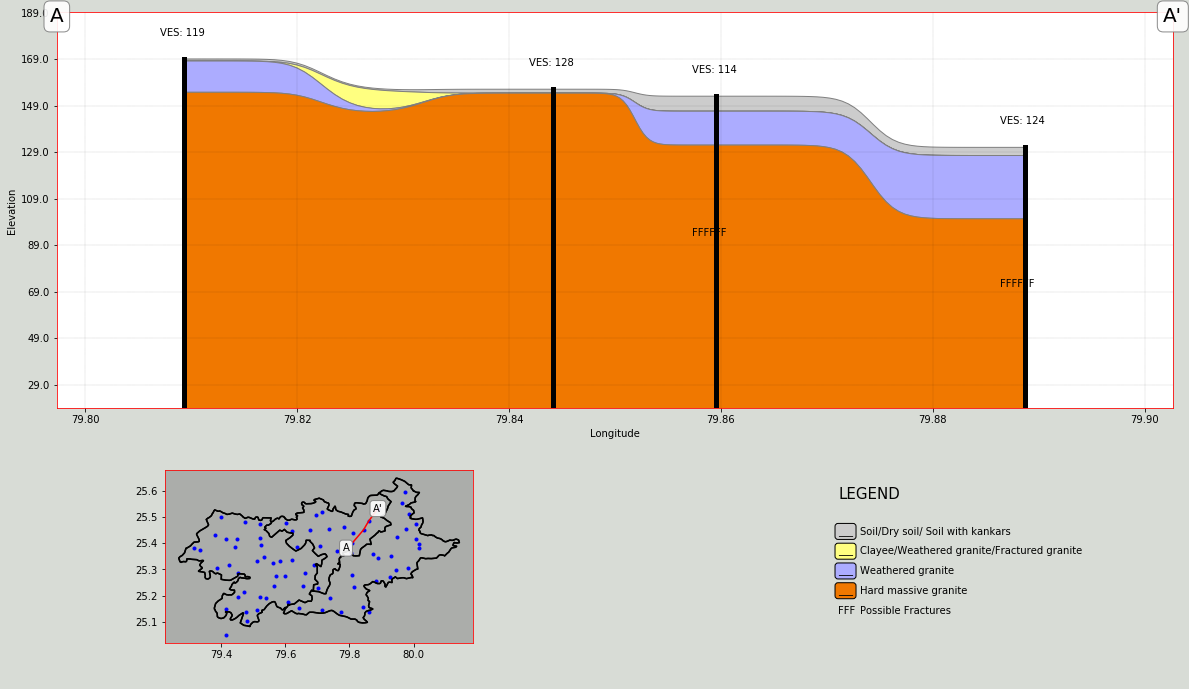

In [521]:

proj=[1,0,0,0,1,0,1,1,1,0]
sec_no=2
for sec_no in range(len(proj)):
#     f,ax=plt.subplots(figsize=(20, 8))
    f, (ax, ax2) = plt.subplots(2, 1, figsize=(20, 12),gridspec_kw = {'height_ratios':[6, 3]})
    f.patch.set_facecolor('xkcd:light gray')
    ax,crooked_line=plot_crosssection(ax,ax2,sections[sec_no],profile_name[sec_no],vesdf,normal_proj=proj[sec_no])
    plot_location_map(plt,crooked_line,profile_name[sec_no])
    plt.rcParams["axes.edgecolor"] = "red"
    plt.show()
    f.savefig(base_folder+'cross-sections//'+profile_name[sec_no]+'_'+'_'.join(sections[sec_no])+'.png',dpi=300)
    break
    # crooked_line
#     sections[0]

In [219]:
crooked_line[:,0]
# for polyset in polysets:
#     for section in polyset:
#         xycoords=section[0]        
#         plt.plot(xycoords[:,0],xycoords[:,1],'*k')

array([ 79.71526,  79.73988,  79.80843,  79.87275,  79.94946,  79.97585,
        80.00813])

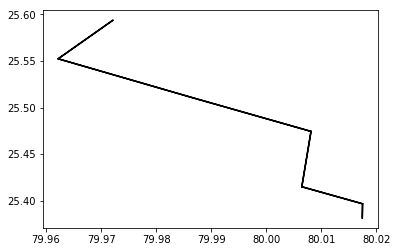

In [72]:
# for xyzcoord in np.array(xyzcoords):
# #     xycoords=section[0]        
#     plt.plot(xyzcoord[:,1],xyzcoord[:,2],'k')
# plt.ylim(-270,70)
# plt.gca().invert_yaxis()


In [59]:
def get_polysFromLayers_mod(elevation,layers,xycoords,xi,yi):
    polys=[]

    ztbs=[]
    depth_on_cl=[]
    indeces=[]
    fyi=np.flipud(yi)
    fxi=np.flipud(xi)
    for xyind in xycoords[:,:]:
#         print(j,end=',')
        indx,indy=np.where(xi==xyind[0])[0],np.where(yi==xyind[1])[0]
        indeces.append([indx,indy])
        depth_on_cl.append(elevation[indy,indx][0])
    depth_on_cl=np.array([depth_on_cl])
#     print(depth_on_cl)
    for i in range(len(layers)):
#         print(i)
        j=0
        thk_on_cl=[]
        for xyind in indeces:
    #         print(j,end=',')
#             indx,indy=np.where(xi==xyind[0])[0],np.where(yi==xyind[1])[0]
            thk_on_cl.append(layers[i][xyind[1],xyind[0]][0])
            j +=1
        #     print(indx,indy)
        depth_on_cl=np.append(depth_on_cl,[depth_on_cl[-1]+thk_on_cl],axis=0)

    polygons=[]
    for i in range(1,len(depth_on_cl)):
    #     poly=[xycoords depth_on_cl
        xyz_top=np.append(xycoords.T,[depth_on_cl[i-1]],axis=0)
        xyz_bot=np.append(xycoords.T,[depth_on_cl[i]],axis=0)
        polygons.append(np.append(xyz_top.T,np.flipud(xyz_bot.T),axis=0))    
    return polygons,depth_on_cl
def crook_triangle(loc,dist=0.005):
    return [[loc[0]-dist,loc[1]-dist],
     [loc[0]+dist,loc[1]-dist],
     [loc[0]+dist,loc[1]],
     [loc[0]-dist,loc[1]-dist],
    ]
def gety(x,points):
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords,ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords)[0]
#     print("Line Solution is y = {m}x + {c}".format(m=m,c=c))
    return m*x+c
def get_indx_of_croockedline(coords,crooked_line):
    myKDTree = spatial.KDTree(coords)
    final_x=[]
    final_y=[]
    for i in range(1,len(crooked_line)):
        point_pair=np.array([crooked_line[i],crooked_line[i-1]])
        print('point_pair: ',point_pair[:,0])

    #     
        sel_xi=xi[xi>=min(point_pair[:,0]) ]
        sel_xi=sel_xi[sel_xi<=max(point_pair[:,0])+sel_xi[1]-sel_xi[0]]
    #     break
        final_x.extend(sel_xi)
        final_y.extend(gety(sel_xi,point_pair))


    #get close_y index
    IND=[]
    for pt in zip(final_x,final_y):
        distance,index=myKDTree.query(pt)
        IND.append(index)
    return IND
def get_indx_of_croockedline_mod(coords,crooked_line):
    myKDTree = spatial.KDTree(coords)
    final_x=[]
    final_y=[]
    IND=[]
    for i in range(1,len(crooked_line)):
        point_pair=np.array([crooked_line[i],crooked_line[i-1]])
#         print('point_pair: ',point_pair[:,0])

    #     
        sel_xi=xi[xi>=min(point_pair[:,0]) ]
        sel_xi=sel_xi[sel_xi<=max(point_pair[:,0])+sel_xi[1]-sel_xi[0]]
    #     break
        final_x.extend(sel_xi)
        sel_yi=gety(sel_xi,point_pair)
        final_y.extend(sel_yi)
        [sel_xi[0],sel_xi[-1]]
        _,index0=myKDTree.query((sel_xi[0],sel_yi[0]))
        _,index1=myKDTree.query((sel_xi[-1],sel_yi[-1]))
#         interval=int(round((index1-index0)/(len(sel_xi)-1)))
#         ind=list(range(index0,index1+1,interval))
        ind=np.int32(np.linspace(index0, index1, len(sel_xi), endpoint=True))
#         diff=index1-ind[-1]
        
#         corr_fact=diff/len(sel_xi)
#         corr_vect=np.round(np.arange(len(sel_xi))*corr_fact)
#         print('diff :{} , corr.fact: {}'.format(diff,corr_fact))
#         print(corr_vect)
        IND.extend(ind)
#         IND.extend()


    #get close_y index
    
#     for pt in zip(final_x,final_y):
#         distance,index=myKDTree.query(pt)
#         IND.append(index)
    return IND
def design_crooked_section(loc_array,vesdf):
    loc_coords=[]
    for loc in loc_array:
        loc_coords.append(vesdf[vesdf['VES No.']==str(loc)][['Easting','Northing']].values.astype(float))
  
    return np.array(loc_coords).ravel().reshape(len(loc_array),2)
def design_crooked_section_w_ele(loc_array,vesdf):
    loc_coords=[]
    for loc in loc_array:
        loc_coords.append(vesdf[vesdf['VES No.']==str(loc)][['Easting','Northing','RL']].values.astype(float))
  
    return np.array(loc_coords).ravel().reshape(len(loc_array),3)
def get_sections():
    profiles=load_pkl(base_folder+'profiles.pkl')
    sections=[]
    for profile in profiles:
        sections.append([p[0] for p in profile])
    return sections   

In [96]:
def iwd(x,y,v,gridsize=(100,100),power=2):
    xi = np.linspace(min(x),max(x),gridsize[0])
    yi = np.linspace(min(y),max(y),gridsize[1])
    grid = np.zeros((len(xi),len(yi)))
    for ix,i in enumerate(xi):
        for jy,j in enumerate(yi):
            distance = np.sqrt((x-i)**2+(y-j)**2)
            if (distance**power).min()==0: 
                grid[ix,jy] = v[(distance**power).argmin()]
            else:
                total = np.sum(1/(distance**power))
                grid[ix,jy] = np.sum(v/(distance**power)/total)
    return grid.T

def iwd_point(x,y,v,xy,power=2):
    distance = np.sqrt((x-xy[0])**2+(y-xy[1])**2)
    if (distance**power).min()==0: 
        est = v[(distance**power).argmin()]
    else:
        total = np.sum(1/(distance**power))
        est = np.sum(v/(distance**power)/total)
    return est
def calc_plot_grid(P,gridsize=(100,100),method='kriging',power=2):    
    xi = np.linspace(min(P[:,0]),max(P[:,0]),gridsize[0])
    yi = np.linspace(min(P[:,1]),max(P[:,1]),gridsize[1])
    fig=plt.figure(figsize=(10,10))
    # grid the data.
    if method=='cubic':
        zi = griddata((P[:,0], P[:,1]), P[:,2], (xi[None,:], yi[:,None]), method='cubic')
    elif method=='kriging':
        zi = np.zeros((len(xi),len(yi)))
        sill=1200
        arange=390
        covfct = model.covariance( model.gaussian, ( arange, sill ) )
        for i,x in enumerate(xi):
            for j,y in enumerate(yi):
                zi[i,j]=kriging.simple( P, covfct,(x,y), N=16)[0]
    elif method=='iwd':
        zi=iwd(P[:,0], P[:,1], P[:,2],gridsize,power=power)
    CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
    plt.colorbar() # draw colorbar
    # plot data points.
    plt.scatter(P[:,0], P[:,1],marker='o',c='b',s=5)
    for p in P:
        plt.annotate(str(int(p[2])),xy=(p[0],p[1]))
#     plt.show()



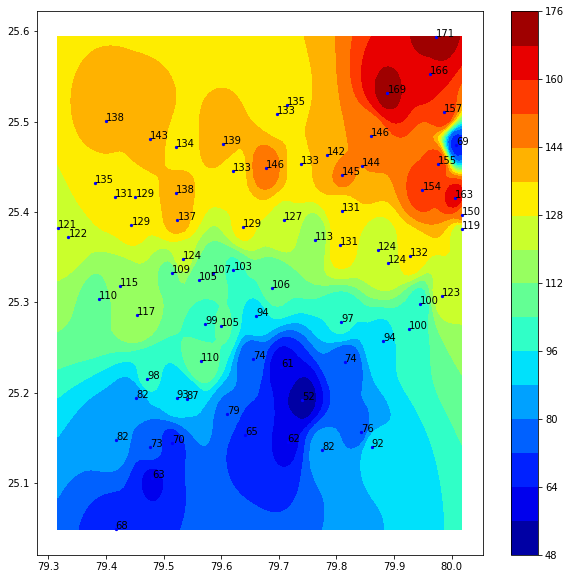

In [101]:
P=xy_final_depths[:,[0,1,-1]]
calc_plot_grid(P,gridsize=(100,100),method='iwd',power=4)

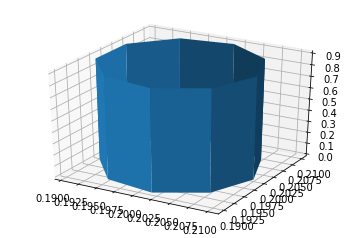

In [310]:
import numpy as np

def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 2)
    theta = np.linspace(0, 2*np.pi, 10)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.2,0.01,0.9)
ax.plot_surface(Xc, Yc, Zc, alpha=1)

plt.show()

In [327]:
data_for_cylinder_along_z(0.2,0.2,0.01,0.9)
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

N = 50
trace1 = go.Mesh3d(x=(30*np.random.randn(N)),
                   y=(25*np.random.randn(N)),
                   z=(30*np.random.randn(N)),
                   opacity=0.5,)


layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                         backgroundcolor="rgb(200, 200, 230)",
                         gridcolor="rgb(255, 255, 255)",
                         showbackground=True,
                         zerolinecolor="rgb(255, 255, 255)",),
                    yaxis = dict(
                        backgroundcolor="rgb(230, 200,230)",
                        gridcolor="rgb(255, 255, 255)",
                        showbackground=True,
                        zerolinecolor="rgb(255, 255, 255)"),
                    zaxis = dict(
                        backgroundcolor="rgb(230, 230,200)",
                        gridcolor="rgb(255, 255, 255)",
                        showbackground=True,
                        zerolinecolor="rgb(255, 255, 255)",),),
                    width=700,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )
fig = go.Figure(data=[trace1], layout=layout)
py.iplot(fig)

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.